In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchsummaryX import summary
from torch.utils.data import Dataset, DataLoader
import zipfile
import pandas as pd
from tqdm import tqdm
import os
import datetime
import warnings

#Dataset Imports
import csv
from IPython.display import Audio, display
import torchaudio
from transformers import Wav2Vec2FeatureExtractor
from torch.nn.utils.rnn import pad_sequence

warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

/home/rvitiell/miniconda3/envs/dl_proj/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device:  cuda


In [3]:
model_name_or_path = "facebook/hubert-large-ls960-ft"
pooling_mode = "mean"

In [4]:
from transformers import Wav2Vec2Processor
processor = Wav2Vec2Processor.from_pretrained(model_name_or_path,)
target_sampling_rate = processor.feature_extractor.sampling_rate
print(f"The target sampling rate: {target_sampling_rate}")

The target sampling rate: 16000


In [5]:
#Set directory to the Audios folder in MSP dataset
NSC_Root = '/data/NO-BACKUP/rvitiell-data/NSC/NSC_part5_labelled_emotion'

In [6]:
# {'A':1, 'S':2, 'H':3, 'U':4, 'F':5, 'D':6, 'C':7, 'N':8, 'O':9}
EMOMAP = {'A':0, 'S':1, 'H':2,'D':3,'N':4}

In [7]:
class NSCDataset(torch.utils.data.Dataset):
    
    def __init__(self): 
        
        self.audio_dir = NSC_Root
        #quick way of looping subdirectories. Dataset only has 4 categories. 
        self.subdirectory = [('/Anger/', 0), ('/Sad/', 1), ('/Happy/', 2), ('/Neutral/', 4)]
        self.audio = []
        self.labels = []
        for sub, label in self.subdirectory:
            NSCaudios = os.listdir(NSC_Root + sub)
            self.audio += [NSC_Root + sub + x for x in NSCaudios]
            self.labels += [label]*len(NSCaudios) 
        #Sanitycheck1
        assert(len(self.audio) == len(self.labels))
        self.length = len(self.audio)
        
    def __len__(self):
        return self.length

    def __getitem__(self, ind):
        audio = self.audio[ind]
        label = self.labels[ind]
        #load audio when getting the item. If we do it in init, computer blue screens.
        waveform, sample_rate = torchaudio.load(audio)
        waveform = processor(waveform, sampling_rate = 16000,padding=True, return_tensors="pt", device=device)
        # waveform = waveform.to(device)
        # label = label.to(device)
        waveform['labels'] = label

        return waveform

In [8]:
import gc 
gc.collect()

0

In [9]:
# Create Dataset objects.
# train_data = MSPDataset(train = True) 
# val_data = MSPDataset(valid = True) 
test_data = NSCDataset()

# print(train_data.__len__())
# print(val_data.__len__())
print(test_data.__len__())

1769


In [10]:
for i, val in enumerate(test_data):
    print(i, val)
    break

0 {'input_values': tensor([[[-0.0183, -0.0629, -0.0203,  ..., -0.8089, -0.7332, -0.8249]]]), 'attention_mask': tensor([[1]], dtype=torch.int32), 'labels': 0}


In [11]:
from datasets import load_dataset, Dataset
NSCtest_dataset = Dataset.from_list(test_data)

In [12]:
# NSCtest_dataset.push_to_hub("dlproject/nsc_test")

In [13]:
# test_dataset = load_dataset("dlproject/nsc_test")

In [14]:
# test_dataset = test_dataset['train']

In [15]:
import numpy as np
from transformers import EvalPrediction
from torchmetrics import F1Score

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.argmax(preds, axis=1)

    f1 = F1Score(num_classes=5,average='weighted')
    return {"accuracy": (preds == p.label_ids).astype(np.float32).mean().item(), "f1": f1(torch.tensor(preds), torch.tensor(p.label_ids))}

In [16]:
# config
from transformers import AutoConfig, Wav2Vec2Processor
config = AutoConfig.from_pretrained("/data/NO-BACKUP/rvitiell-data/MSP/models/hubert-fixed-10epoch/checkpoint-232")
setattr(config, 'pooling_mode', pooling_mode)

In [17]:
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from transformers.file_utils import ModelOutput
from dataclasses import dataclass
from typing import Optional, Tuple
import torch

from transformers.models.wav2vec2.modeling_wav2vec2 import (
    Wav2Vec2PreTrainedModel,
    Wav2Vec2Model
)

@dataclass
class SpeechClassifierOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None


class Wav2Vec2ClassificationHead(nn.Module):
    """Head for wav2vec classification task."""

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.final_dropout)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x


class Wav2Vec2ForSpeechClassification(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.pooling_mode = config.pooling_mode
        self.config = config

        self.wav2vec2 = Wav2Vec2Model(config)
        self.classifier = Wav2Vec2ClassificationHead(config)

        self.init_weights()

    def freeze_feature_extractor(self):
        self.wav2vec2.feature_extractor._freeze_parameters()

    def merged_strategy(
            self,
            hidden_states,
            mode="mean"
    ):
        if mode == "mean":
            outputs = torch.mean(hidden_states, dim=1)
        elif mode == "sum":
            outputs = torch.sum(hidden_states, dim=1)
        elif mode == "max":
            outputs = torch.max(hidden_states, dim=1)[0]
        else:
            raise Exception(
                "The pooling method hasn't been defined! Your pooling mode must be one of these ['mean', 'sum', 'max']")

        return outputs

    def forward(
            self,
            input_values,
            attention_mask=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
            labels=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.wav2vec2(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = outputs[0]
        hidden_states = self.merged_strategy(hidden_states, mode=self.pooling_mode)
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SpeechClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


In [18]:
from transformers import HubertForSequenceClassification
model = HubertForSequenceClassification.from_pretrained(
    "/data/NO-BACKUP/rvitiell-data/MSP/models/hubert-fixed-10epoch/checkpoint-232",
    config=config,
    ignore_mismatched_sizes=True,
)

In [19]:
model = model.to(device)

In [20]:
import datasets
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
from tqdm.auto import tqdm

#pipe = pipeline("audio-classification",model="/content/wav2vec2-xlsr-speech-emotion-recognition/checkpoint-3600", device=0)
#dataset = datasets.load_dataset("superb", name="asr", split="test")

def create_batches(data, batch_size=8):
    all_batches = []
    for batch_num in range(0,len(data),batch_size):
        batch = []
        for i in range(0,batch_size): 
            try:
                batch.append({"input_values":data[batch_num+i]['input_values'][0][0]})
            except:
                batch.append
                #print(len(batch[1]))
        input_values = processor.pad(
            batch,
            padding=True,
            max_length=None,
            pad_to_multiple_of=None,
            return_tensors="pt",
            )
        all_batches.append(input_values.to(device))
    return all_batches

all_batches = create_batches(NSCtest_dataset)

In [21]:
def predict(all_batches):
    #features = processor(batch["speech"], sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt", padding=True)
    #print(inp)
    all_batch_predictions = []
    for batch in all_batches:
        #print(torchbatch['input_values'][0][0])
        
        attention_mask = batch['attention_mask'].to(device)

        with torch.no_grad():
            logits = model(batch['input_values'], attention_mask=attention_mask).logits 

        pred_ids = torch.argmax(logits, dim=-1).detach().cpu().numpy()
        all_batch_predictions.append(pred_ids)
        
    return all_batch_predictions

In [22]:
result = predict(all_batches)

In [23]:
from sklearn.metrics import classification_report
from torchmetrics import F1Score
def get_metrics(result, gt):
    all_preds = []
    for _, batch_result in enumerate(tqdm(result)):
        all_preds.extend(batch_result)
        
    all_gt = []
    for _, record in enumerate(tqdm(gt)):
        all_gt.append(record['labels'])
    print(classification_report(all_gt, all_preds, digits=4))
    f1 = F1Score(num_classes=5,average='weighted')
    print("F1 score:")
    print(f1(torch.tensor(all_preds), torch.tensor(all_gt)))
    

In [24]:
get_metrics(result, test_data)

100%|██████████| 1769/1769 [00:01<00:00, 914.65it/s]

              precision    recall  f1-score   support

           0     0.8000    0.1043    0.1846       115
           1     0.0000    0.0000    0.0000        16
           2     0.4490    0.5641    0.5000        39
           4     0.9241    0.9819    0.9521      1599

    accuracy                         0.9067      1769
   macro avg     0.5433    0.4126    0.4092      1769
weighted avg     0.8972    0.9067    0.8836      1769

F1 score:
tensor(0.8836)


In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def get_confusion_matrix(result, gt):
    all_preds = []
    for _, batch_result in enumerate(tqdm(result)):
        all_preds.extend(batch_result)
        
    all_gt = []
    for _,record in enumerate(tqdm(gt)):
        all_gt.append(record['labels'])
    
    cm = confusion_matrix(all_gt, all_preds)
    print(cm)
    return cm

In [26]:
cm = get_confusion_matrix(result, test_data)

100%|██████████| 1769/1769 [00:01<00:00, 917.18it/s]

[[  12    0    7   96]
 [   0    0    0   16]
 [   0    0   22   17]
 [   3    6   20 1570]]


In [27]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['A', 'S', 'H', 'N'])

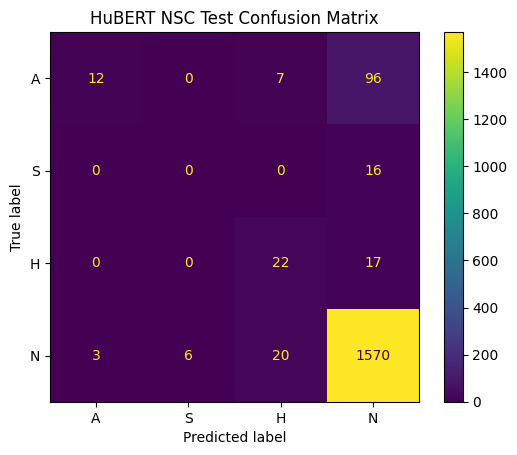

In [28]:
disp.plot()
plt.title("HuBERT NSC Test Confusion Matrix")
plt.show()

In [ ]:
# import pickle
# with open('result.pkl', 'wb') as f:
#     pickle.dump(result, f)

# VAL

In [29]:
class MSPDataset(torch.utils.data.Dataset):
    
    #Initialize the dataset based on the recommended split in MSP dataset.
    def __init__(self, train = False, valid = False, test1 = False, test2 = False): 
        
        self.audio_dir = AUDIO_ROOT
        self.labels_dir = LABELS_DIR
        self.audio_names = sorted(names)
        self.labels_list = labels
        self.EMOMAP = EMOMAP

        self.audio = []
        self.labels = []
        
        #What type of dataset are we making
        setType = 'Train'
        if valid:
            setType = 'Validation'
        elif test1:
            setType = 'Test1'
        elif test2:
            setType = 'Test2'
        print(setType)       
        
        #Sanitycheck1
        assert(len(self.audio_names) == len(self.labels_list))
        
        for i in tqdm(range(0, len(self.audio_names))):
            assert(self.audio_names[i] == self.labels_list[i][0])
            if self.labels_list[i][7] != setType or self.labels_list[i][1] == 'X' or self.labels_list[i][1] not in self.EMOMAP.keys():
                continue
            #43 Audio files from 1904 podcast seems to be broken. Torchaudio load returns 'no data chunk'
            if self.labels_list[i][0].startswith('MSP-PODCAST_1904'):
                continue
            self.audio.append(self.audio_dir + self.audio_names[i])
            self.labels.append(self.EMOMAP[self.labels_list[i][1]])         
        
        self.length = len(self.audio)
        
    def __len__(self):
        return self.length

    def __getitem__(self, ind):
        audio = self.audio[ind]
        label = self.labels[ind]
        #load audio when getting the item. If we do it in init, computer blue screens.
        waveform, sample_rate = torchaudio.load(audio)

        waveform = processor(waveform, sampling_rate = 16000,padding=True, device = device)

        # waveform = waveform.to(device)
        # label = label.to(device)
        waveform['labels'] = label

        return waveform
        #return waveform, label
    
    # def collate_fn(self, batch):
    #     batch_audio = [x[0].reshape(-1) for x in batch]

    #     audio_lengths = torch.LongTensor([len(x) for x in batch_audio])
    #     batch_audio = pad_sequence(batch_audio, padding_value=0.0, batch_first = True)
    #     batch_label = [x[1] for x in batch]
        
    #     return batch_audio, audio_lengths, torch.tensor(batch_label)

In [30]:
#Set directory to the Audios folder in MSP dataset
AUDIO_ROOT = '/data/NO-BACKUP/rvitiell-data/MSP/Audios/'
#Set path to labels_consensus in MSP dataset
LABELS_DIR = '/data/NO-BACKUP/rvitiell-data/MSP/labels/'

In [31]:
#Load the directory
names = sorted(os.listdir(AUDIO_ROOT))
data1 = AUDIO_ROOT + names[0]
#torchaudio.load requires you to install some programs if you get 'No audio I/O backend is available' error
#https://stackoverflow.com/questions/62543843/cannot-import-torch-audio-no-audio-backend-is-available
waveform, sample_rate = torchaudio.load(data1)
print(waveform.shape)
print(sample_rate)

#Load label csv file
with open(LABELS_DIR + 'labels_concensus.csv') as f:
    reader = csv.reader(f)
    labels = sorted(list(reader)[1:])

torch.Size([1, 167814])
16000


In [32]:
val_data = MSPDataset(valid = True)

Validation


100%|██████████| 73042/73042 [00:00<00:00, 1296845.74it/s]


In [33]:
val_dataset = Dataset.from_list(val_data)

In [34]:
all_batches_MSP = create_batches(val_dataset)

In [35]:
result_MSP = predict(all_batches_MSP)

In [36]:
get_metrics(result_MSP, val_data)

100%|██████████| 5213/5213 [00:20<00:00, 250.56it/s]

              precision    recall  f1-score   support

           0     0.4773    0.5749    0.5215       621
           1     0.3571    0.0166    0.0316       302
           2     0.6179    0.6432    0.6303      1320
           3     0.0000    0.0000    0.0000       441
           4     0.6412    0.7802    0.7039      2529

    accuracy                         0.6108      5213
   macro avg     0.4187    0.4030    0.3775      5213
weighted avg     0.5451    0.6108    0.5650      5213

F1 score:
tensor(0.5650)


In [37]:
cm2 = get_confusion_matrix(result_MSP, val_data)

100%|██████████| 5213/5213 [00:09<00:00, 528.94it/s]

[[ 357    1   65    0  198]
 [  17    5   43    0  237]
 [  30    0  849    0  441]
 [ 135    2   76    0  228]
 [ 209    6  341    0 1973]]


In [38]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=['A', 'S', 'H', 'D', 'N'])

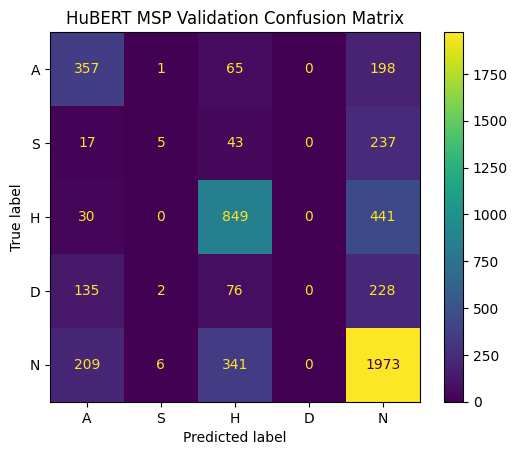

In [39]:
disp.plot()
plt.title("HuBERT MSP Validation Confusion Matrix")
plt.show()